## Final Project Submission

Please fill out:
* Student name: Charlie Losche
* Student pace: full time
* Scheduled project review date/time: 8/1/2022
* Instructor name: David Elliot
* Blog post URL:N/A


In [1]:
# Your code here - remember to use markdown cells for comments as well!

In [2]:
#import 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

%matplotlib inline

# Attempting Sklearn predictive model with our current regression model

In [3]:
df = pd.read_csv('./data/kc_house_data.csv',
                parse_dates=['date'])

df.drop(['id', 'floors',
         'heat_source','lat','long'], axis=1, inplace=True)

# Create zip from address
df['zip'] = [x.split(',')[2][-5:] for x in df['address']] 

#https://www.zillow.com/browse/homes/wa/king-county/  - remove all records with zipcodes that dont start with '98'
df = df[df.zip.str.startswith(('98'))]

df['city'] = [x.split(',')[1][0:] for x in df['address']]

#create sale year column from datetime date info
df['sale_year'] = pd.DatetimeIndex(df['date']).year.astype(int)

df['sale_year'].value_counts()


#create new column - age of house
df['home_age'] = (df['sale_year']+1) - df['yr_built']

#create new column - time since reno
df['yr_from_reno'] = (df['sale_year']+1) - df['yr_renovated']

# create filter for yr_from_reno to ID houses that haven't been renovated
reno_filter = df['yr_from_reno'] > 2000

# create new column for design_age to see time since build if no reno, or time since reno if renovated
# first set to reno age
df['design_age'] = df['yr_from_reno']
#then update columns where there was no reno to age of the home
df['design_age'].loc[reno_filter] = df['home_age']

#some houses were sold before they were built - we need to change those records to 0

prebuild_filter = df['design_age'] < 1

df['design_age'].loc[prebuild_filter] = 1


grade_cat = df[['grade']]
grade_categories = ['1 Cabin', '2 Substandard', '3 Poor', '4 Low', '5 Fair', '6 Low Average',
                    '7 Average', '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']
encoder_grade = OrdinalEncoder(categories=[grade_categories])
encoder_grade.fit(grade_cat)
grade_encoded_train = encoder_grade.transform(grade_cat)
grade_encoded_train = grade_encoded_train.flatten()
df["grade"] = grade_encoded_train

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [4]:
len(df['city'].value_counts())

63

Updating the df to only include homes tham meet minimum code requirements - Average grade of construction and design, and up to homes where finish work is better and more design quality

In [5]:
grade_filter1 = df["grade"] > 5 
grade_filter2 = df["grade"] < 11

In [6]:
df = df.loc[grade_filter1 & grade_filter2]

In [7]:
len(df['city'].value_counts())

61

In [8]:
df['city'].value_counts()

 Seattle            8081
 Renton             1633
 Kent               1466
 Bellevue           1417
 Auburn             1288
                    ... 
 Dilworth              1
 Cottage Lake          1
 Ames Lake             1
 Fairwood              1
 Snoqualmie Pass       1
Name: city, Length: 61, dtype: int64

In [9]:
df_city = df.groupby('city').count()['price'].reset_index()
city_columns = df_city[ df_city['price'] >= 30 ].transpose()
city_columns.columns = city_columns.iloc[0]
len(city_columns.columns)

36

In [10]:
drop_city = df.groupby('city').count()['price'].reset_index()
drop_city_columns = drop_city[ drop_city['price'] < 30 ].transpose()
drop_city_columns.columns = drop_city_columns.iloc[0]
drop_city_columns.columns

Index([' Algona', ' Ames Lake', ' Arlington', ' Beaux Arts', ' Cottage Lake',
       ' Dash Point', ' Dilworth', ' Eatonville', ' Fairwood', ' Hobart',
       ' Hunts Point', ' Lakeland North', ' Marysville', ' Milton', ' Monroe',
       ' Preston', ' Puyallup', ' Skykomish', ' Snohomish', ' Snoqualmie Pass',
       ' Spanaway', ' Tulalip', ' Union Hill-Novelty Hill', ' Vancouver',
       ' Yarrow Point'],
      dtype='object', name='city')

In [11]:
drop_city = list(drop_city_columns.columns)

drop_city

[' Algona',
 ' Ames Lake',
 ' Arlington',
 ' Beaux Arts',
 ' Cottage Lake',
 ' Dash Point',
 ' Dilworth',
 ' Eatonville',
 ' Fairwood',
 ' Hobart',
 ' Hunts Point',
 ' Lakeland North',
 ' Marysville',
 ' Milton',
 ' Monroe',
 ' Preston',
 ' Puyallup',
 ' Skykomish',
 ' Snohomish',
 ' Snoqualmie Pass',
 ' Spanaway',
 ' Tulalip',
 ' Union Hill-Novelty Hill',
 ' Vancouver',
 ' Yarrow Point']

In [12]:
len(df)

25777

In [13]:
for city in drop_city:
    df = df[~df.city.str.contains(city)]

In [14]:
len(df)

25655

Updating the df to only include homes tham meet minimum code requirements - Average grade of construction and design, and up to homes where finish work is better and more design quality

In [15]:
len(df['city'].value_counts())

36

### Binning data to sqft living over 500 sqft

https://www.seattle.gov/Documents/Departments/SDCI/Codes/SingleFamilyZoningSummary.pdf

https://getjerry.com/questions/how-many-square-feet-is-a-2-car-garage

According to the zoning proposal above, small, single family (larger cottage style) homes have a total square feet of 1,400 - assuming garage is the only non-living area, and the average 2 car garage is 360 sqft (from Jerry above)

- minimim living sqft should be 1000 (giving extra flex room for garage)

Given the fact that we're not building mansions, just single family homes, if we build detached homes with total area of 2200 sqft, we'd get access to the FAR preservation incentive.

In [16]:
len(df)

25655

In [17]:
sqft_filter1 = df["sqft_living"] > 1100

In [18]:
df = df.loc[sqft_filter1]

In [19]:
len(df)

24257

In [20]:
y = df["price"]
X = df.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

In [21]:
print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

print(f"X_test is a DataFrame with {X_test.shape[0]} rows and {X_test.shape[1]} columns")
print(f"y_test is a Series with {y_test.shape[0]} values")

X_train is a DataFrame with 18192 rows and 25 columns
y_train is a Series with 18192 values
X_test is a DataFrame with 6065 rows and 25 columns
y_test is a Series with 6065 values


In [22]:

# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
X_train.loc[X_train['bathrooms'] == 0, 'bathrooms'] = 1
X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)


# Create binary substitutes for columns
X_train['basement_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_basement']]
X_train['garage_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_garage']]
X_train['patio_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_patio']]
X_train['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in X_train['waterfront']]
X_train['PublicSewer_binary'] = [1 if sq == 'PUBLIC' else 0 for sq in X_train['sewer_system']]
X_train['yrenovated_binary'] = [1 if sq >  0 else 0 for sq in X_train['yr_renovated']]


# Create binary values for greenbelt, nuisance
# Using OneHotEncoder

greenbelt_cat = X_train[['greenbelt']]
encoder_greenbelt = OrdinalEncoder(categories=[['NO', 'YES']])
encoder_greenbelt.fit(greenbelt_cat)
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
X_train["greenbelt"] = greenbelt_encoded_train

nuisance_cat = X_train[['nuisance']]
encoder_nuisance = OrdinalEncoder()
encoder_nuisance.fit(nuisance_cat)
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
X_train["nuisance"] = nuisance_encoded_train

# Create Ordinal Values for condition
# Using OneHotEncoder
condition_cat = X_train[['condition']]
condition_categories = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
encoder_condition = OrdinalEncoder(categories=[condition_categories])
encoder_condition.fit(condition_cat)
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
X_train["condition"] = condition_encoded_train

# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = X_train[['view']]
view_categories = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
encoder_view = OrdinalEncoder(categories=[view_categories])
encoder_view.fit(view_cat)
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
X_train["view"] = view_encoded_train


# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
city_train = X_train[["city"]]

ohe_city = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe_city.fit(city_train)

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
city_encoded_train = ohe_city.transform(city_train)

# Visually inspect fireplace_qu_encoded_train
city_encoded_train

# (5a) Make the transformed data into a dataframe
city_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    city_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe_city.categories_[0],
    # Set the index to match X_test's index
    index=X_train.index
)

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_train.drop("city", axis=1, inplace=True)

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_train
X_train = pd.concat([X_train, city_encoded_train], axis=1)

# Visually inspect X_train
X_train.head()

# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
fireplace_qu_train = X_train[["zip"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe_zip = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe_zip.fit(fireplace_qu_train)

# Inspect the categories of the fitted encoder
ohe_zip.categories_

# Replace None with appropriate code

# (4) Transform fireplace_qu_train using the encoder and
# assign the result to fireplace_qu_encoded_train
fireplace_qu_encoded_train = ohe_zip.transform(fireplace_qu_train)

# Visually inspect fireplace_qu_encoded_train
fireplace_qu_encoded_train

# Run this cell without changes

# (5a) Make the transformed data into a dataframe
fireplace_qu_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    fireplace_qu_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe_zip.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)

# Visually inspect new dataframe
fireplace_qu_encoded_train

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_train.drop("zip", axis=1, inplace=True)

# Visually inspect X_train

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_train
X_train = pd.concat([X_train, fireplace_qu_encoded_train], axis=1)

# Visually inspect X_train
X_train.head()

# Create 'total_sqft' by combining sqft_above + sqft_basement + 
# sqft_garage + sqft_patio
X_train['total_sqft'] = X_train['sqft_above'] + X_train['sqft_basement'] + X_train['sqft_garage'] + X_train['sqft_patio']

X_train['weighted__livsqft'] = X_train['sqft_living'] * X_train['grade']

X_train['date'] = pd.to_datetime(X_train['date'], format='%Y-%m-%d')

X_train['date'].head()

#create sale year column from datetime date info
X_train['sale_year'] = pd.DatetimeIndex(X_train['date']).year.astype(int)

X_train['sale_year'].value_counts()

#Binning by decade

X_train['design_decade'] = pd.cut(x=X_train['design_age'], bins=[0, 3, 13, 23, 33, 43, 53, 63, 73,
                                                         83, 93, 103, 113, 123],
                    labels=['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s',
                            '1950s', '1940s', '1930s', '1920s', '1910s', '1900s'])

X_train.design_decade.value_counts()

labels_ordered = ['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s','1950s', '1940s', '1930s', '1920s', '1910s', '1900s']

labels_ordered.reverse()

labels_ordered

# Create Ordinal Values for view
# Using OneHotEncoder
age_cat = X_train[['design_decade']]
age_categories = labels_ordered
encoder_age = OrdinalEncoder(categories=[age_categories])
encoder_age.fit(age_cat)
encoder_age.categories_[0]

age_encoded_train = encoder_age.transform(age_cat)
age_encoded_train = age_encoded_train.flatten()
X_train["design_decade"] = age_encoded_train

X_train["design_decade"]

X_train['yard_size_ratio'] = (X_train['total_sqft'] / X_train['sqft_lot']) * 100

list(X_train.columns)



/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-22-0a659a68db35>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)
<ipython-input-22-0a659a68db35>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

['date',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'condition',
 'grade',
 'sewer_system',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'yr_renovated',
 'address',
 'sale_year',
 'home_age',
 'yr_from_reno',
 'design_age',
 'basement_binary',
 'garage_binary',
 'patio_binary',
 'waterfront_binary',
 'PublicSewer_binary',
 'yrenovated_binary',
 ' Auburn',
 ' Bellevue',
 ' Black Diamond',
 ' Bothell',
 ' Burien',
 ' Carnation',
 ' Clyde Hill',
 ' Covington',
 ' Des Moines',
 ' Duvall',
 ' Enumclaw',
 ' Fall City',
 ' Federal Way',
 ' Issaquah',
 ' Kenmore',
 ' Kent',
 ' Kirkland',
 ' Lake Forest Park',
 ' Maple Valley',
 ' Medina',
 ' Mercer Island',
 ' Newcastle',
 ' Normandy Park',
 ' North Bend',
 ' Pacific',
 ' Ravensdale',
 ' Redmond',
 ' Renton',
 ' Sammamish',
 ' SeaTac',
 ' Seattle',
 ' Shoreline',
 ' Snoqualmie',
 ' Tukwila',
 ' Vashon',
 ' Woodinville',
 '98001',
 '98002',
 '98003

In [23]:
X_train['view_grade'] = (X_train['view'] + 1) * X_train['grade']
X_train['waterfront_grade'] = (X_train['waterfront_binary'] + 1)  * X_train['grade']
X_train['design_decade_grade'] = (X_train['design_decade'] + 1)  * X_train['grade']
X_train['nuisance_grade'] = (X_train['nuisance'] + 1)  * X_train['grade']
X_train['garage_binary_grade'] = (X_train['garage_binary'] + 1)  * X_train['grade']
X_train['basement_binary_grade'] = (X_train['basement_binary'] + 1)  * X_train['grade']
X_train['patio_binary_grade'] = (X_train['patio_binary'] + 1)  * X_train['grade']
X_train['PublicSewer_binary_grade'] = (X_train['PublicSewer_binary'] + 1)  * X_train['grade']
X_train['condition_grade'] = (X_train['condition'] + 1)  * X_train['grade']

In [24]:
relevant = [' Auburn', ' Bellevue', ' Black Diamond', ' Bothell', ' Burien',
           ' Carnation', ' Clyde Hill', ' Covington', ' Des Moines', ' Duvall',
           ' Enumclaw', ' Fall City', ' Federal Way', ' Issaquah', ' Kenmore',
           ' Kent', ' Kirkland', ' Lake Forest Park', ' Maple Valley', ' Medina',
           ' Mercer Island', ' Newcastle', ' Normandy Park', ' North Bend',
           ' Pacific', ' Ravensdale', ' Redmond', ' Renton', ' Sammamish',
           ' SeaTac', ' Seattle', ' Shoreline', ' Snoqualmie', ' Tukwila',
           ' Vashon', ' Woodinville',
            'weighted__livsqft', 'design_decade', 'yard_size_ratio', 'view_grade',
            'waterfront_grade', 'design_decade_grade', 'nuisance_grade', 'garage_binary_grade',
            'basement_binary_grade', 'patio_binary_grade', 'PublicSewer_binary_grade', 'condition_grade']

X_train = X_train[relevant]

In [25]:
X_train.view_grade.value_counts()

6.0     7197
7.0     5585
8.0     2177
9.0      742
21.0     471
18.0     384
24.0     372
28.0     185
10.0     165
40.0     144
32.0     138
27.0     114
30.0     107
36.0      97
35.0      91
45.0      67
14.0      43
50.0      41
12.0      37
16.0      30
20.0       5
Name: view_grade, dtype: int64

In [26]:
model_train = sm.OLS(y_train, sm.add_constant(X_train)).fit()
results_train = model_train.summary()
results_train

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     699.6
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        08:52:25   Log-Likelihood:            -2.6415e+05
No. Observations:               18192   AIC:                         5.284e+05
Df Residuals:                   18144   BIC:                         5.288e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -4.273e+05   4.11e+04    -10.384      0.000   -5.08e+05   -3.47e+05
 Auburn                  -4.982e+05   1.72e+04    -28.988      0.000   -5.32e+05   -4.64e+05
 Bellevue                 4.779e+05   1.68e+04     28.531      0.000    4.45e+05    5.11e+05
 Black Diamond            -5.22e+05   3.56e+04    -14.643      0.000   -5.92e+05   -4.52e+05
 Bothell                  1.233e+04   3.42e+04      0.361      0.718   -5.47e+04    7.94e+04
 Burien                  -3.396e+05   2.93e+04    -11.580      0.000   -3.97e+05   -2.82e+05
 Carnation               -2.543e+05   4.92e+04     -5.166      0.000   -3.51e+05   -1.58e+05
 Clyde Hill               2.389e+06   7.21e+04     33.153      0.000    2.25e+06    2.53e+06
 Covington               -4.116e+05   2.87e+04    -14.354      0.000   -4.68e+05   -3.55e+05
 Des Moines              -3.998e+05   3.09e+04    -12.930      0.000    -4.6e+05   -3.39e+05
 Duvall                  -2.566e+05   3.69e+04     -6.960      0.000   -3.29e+05   -1.84e+05
 Enumclaw                -4.637e+05   3.09e+04    -15.020      0.000   -5.24e+05   -4.03e+05
 Fall City                2.923e+05   5.94e+04      4.920      0.000    1.76e+05    4.09e+05
 Federal Way             -5.204e+05   1.89e+04    -27.581      0.000   -5.57e+05   -4.83e+05
 Issaquah                 6.823e+04   2.58e+04      2.642      0.008    1.76e+04    1.19e+05
 Kenmore                 -9.914e+04   3.14e+04     -3.160      0.002   -1.61e+05   -3.76e+04
 Kent                      -4.4e+05   1.64e+04    -26.839      0.000   -4.72e+05   -4.08e+05
 Kirkland                 4.009e+05   1.77e+04     22.700      0.000    3.66e+05    4.35e+05
 Lake Forest Park        -1.085e+05   3.84e+04     -2.822      0.005   -1.84e+05   -3.31e+04
 Maple Valley            -3.542e+05   2.07e+04    -17.115      0.000   -3.95e+05   -3.14e+05
 Medina                   2.436e+06   8.91e+04     27.330      0.000    2.26e+06    2.61e+06
 Mercer Island             6.55e+05   3.18e+04     20.565      0.000    5.93e+05    7.17e+05
 Newcastle               -5.604e+04    4.2e+04     -1.335      0.182   -1.38e+05    2.62e+04
 Normandy Park           -3.898e+05    5.6e+04     -6.955      0.000      -5e+05    -2.8e+05
 North Bend              -2.416e+05   2.79e+04     -8.674      0.000   -2.96e+05   -1.87e+05
 Pacific                 -3.753e+05   7.09e+04     -5.294      0.000   -5.14e+05   -2.36e+05
 Ravensdale              -3.421e+05   7.63e+04     -4.484      0.000   -4.92e+05   -1.93e+05
 Redmond                   2.43e+05   1.95e+04     12.441      0.000    2.05e+05    2.81e+05
 Renton                  -3.158e+05   1.56e+04    -20.197      0.000   -3.46e+05   -2.85e+05
 Sammamish                1.583e+05   1.96e+04      8.097      0.000     1.2e+05    1.97e+05
 SeaTac       

In [27]:
X_test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,greenbelt,nuisance,view,condition,...,sqft_patio,yr_built,yr_renovated,address,zip,city,sale_year,home_age,yr_from_reno,design_age
4403,2021-09-14,3,2.5,2446,9600,NO,NO,NO,NONE,Average,...,0,1968,2014,"14829 Southeast 172nd Place, Renton, Washingto...",98058,Renton,2021,54,8,8
23657,2021-07-14,3,2.0,1650,18124,NO,NO,NO,NONE,Average,...,0,1989,0,"2228 Northeast 12th Street, Renton, Washington...",98056,Renton,2021,33,2022,33
16990,2021-10-07,3,2.0,1450,9639,NO,NO,NO,NONE,Very Good,...,240,1978,0,"16966 431st Ave SE, North Bend, Washington 980...",98045,North Bend,2021,44,2022,44
18877,2021-07-09,4,3.0,2600,11700,NO,NO,NO,GOOD,Good,...,550,1966,0,"13031 Shorewood Drive Southwest, Burien, Washi...",98146,Burien,2021,56,2022,56
13529,2022-03-04,4,1.0,1500,5000,NO,NO,NO,NONE,Average,...,200,1942,0,"3463 Belvidere Avenue Southwest, Seattle, Wash...",98126,Seattle,2022,81,2023,81


In [28]:
# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
X_test.loc[X_test['bathrooms'] == 0, 'bathrooms'] = 1
X_test['bathrooms'] = X_test['bathrooms'].apply(np.ceil)


# Create binary substitutes for columns
X_test['basement_binary'] = [1 if sq >  0  else 0 for sq in X_test['sqft_basement']]
X_test['garage_binary'] = [1 if sq >  0  else 0 for sq in X_test['sqft_garage']]
X_test['patio_binary'] = [1 if sq >  0  else 0 for sq in X_test['sqft_patio']]
X_test['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in X_test['waterfront']]
X_test['PublicSewer_binary'] = [1 if sq == 'PUBLIC' else 0 for sq in X_test['sewer_system']]
X_test['yrenovated_binary'] = [1 if sq >  0 else 0 for sq in X_test['yr_renovated']]


# Create binary values for greenbelt, nuisance
# Using OneHotEncoder

greenbelt_cat = X_test[['greenbelt']]
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
X_test["greenbelt"] = greenbelt_encoded_train

nuisance_cat = X_test[['nuisance']]
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
X_test["nuisance"] = nuisance_encoded_train

# Create Ordinal Values for condition
# Using OneHotEncoder
condition_cat = X_test[['condition']]
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
X_test["condition"] = condition_encoded_train

# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = X_test[['view']]
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
X_test["view"] = view_encoded_train


# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
city_train = X_test[["city"]]

city_encoded_train = ohe_city.transform(city_train)

# Visually inspect fireplace_qu_encoded_train
city_encoded_train

# (5a) Make the transformed data into a dataframe
city_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    city_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe_city.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_test.drop("city", axis=1, inplace=True)

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_test
X_test = pd.concat([X_test, city_encoded_train], axis=1)

# Visually inspect X_test
X_test.head()

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-28-5c10affee70f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['bathrooms'] = X_test['bathrooms'].apply(np.ceil)
<ipython-input-28-5c10affee70f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,date,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,greenbelt,nuisance,view,condition,...,Redmond,Renton,Sammamish,SeaTac,Seattle,Shoreline,Snoqualmie,Tukwila,Vashon,Woodinville
4403,2021-09-14,3,3.0,2446,9600,NO,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23657,2021-07-14,3,2.0,1650,18124,NO,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16990,2021-10-07,3,2.0,1450,9639,NO,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18877,2021-07-09,4,3.0,2600,11700,NO,0.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13529,2022-03-04,4,1.0,1500,5000,NO,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [29]:

# (1) Create a variable zip
# extracted from df
# (double brackets due to shape expected by OHE)
fireplace_qu_train = X_test[["zip"]]

# Replace None with appropriate code

# (4) Transform fireplace_qu_train using the encoder and
# assign the result to fireplace_qu_encoded_train
fireplace_qu_encoded_train = ohe_zip.transform(fireplace_qu_train)

# Visually inspect fireplace_qu_encoded_train
fireplace_qu_encoded_train

# Run this cell without changes

# (5a) Make the transformed data into a dataframe
fireplace_qu_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    fireplace_qu_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe_zip.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# Visually inspect new dataframe
fireplace_qu_encoded_train

# Run this cell without changes

# (5b) Drop original FireplaceQu column
X_test.drop("zip", axis=1, inplace=True)

# Visually inspect X_test

# Run this cell without changes

# (5c) Concatenate the new dataframe with current X_test
X_test = pd.concat([X_test, fireplace_qu_encoded_train], axis=1)

# Visually inspect X_test
X_test.head()

# Create 'total_sqft' by combining sqft_above + sqft_basement + 
# sqft_garage + sqft_patio
X_test['total_sqft'] = X_test['sqft_above'] + X_test['sqft_basement'] + X_test['sqft_garage'] + X_test['sqft_patio']

X_test['weighted__livsqft'] = X_test['sqft_living'] * X_test['grade']

X_test['date'] = pd.to_datetime(X_test['date'], format='%Y-%m-%d')

X_test['date'].head()

#create sale year column from datetime date info
X_test['sale_year'] = pd.DatetimeIndex(X_test['date']).year.astype(int)

X_test['sale_year'].value_counts()

#Binning by decade

X_test['design_decade'] = pd.cut(x=X_test['design_age'], bins=[0, 3, 13, 23, 33, 43, 53, 63, 73,
                                                         83, 93, 103, 113, 123],
                    labels=['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s',
                            '1950s', '1940s', '1930s', '1920s', '1910s', '1900s'])

X_test.design_decade.value_counts()

labels_ordered = ['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s','1950s', '1940s', '1930s', '1920s', '1910s', '1900s']

labels_ordered.reverse()

labels_ordered

# Create Ordinal Values for view
# Using OneHotEncoder
age_cat = X_test[['design_decade']]
age_categories = labels_ordered
age_encoded_train = encoder_age.transform(age_cat)
age_encoded_train = age_encoded_train.flatten()
X_test["design_decade"] = age_encoded_train

X_test["design_decade"]

X_test['yard_size_ratio'] = (X_test['total_sqft'] / X_test['sqft_lot']) * 100

list(X_test.columns)

['date',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'condition',
 'grade',
 'sewer_system',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'yr_renovated',
 'address',
 'sale_year',
 'home_age',
 'yr_from_reno',
 'design_age',
 'basement_binary',
 'garage_binary',
 'patio_binary',
 'waterfront_binary',
 'PublicSewer_binary',
 'yrenovated_binary',
 ' Auburn',
 ' Bellevue',
 ' Black Diamond',
 ' Bothell',
 ' Burien',
 ' Carnation',
 ' Clyde Hill',
 ' Covington',
 ' Des Moines',
 ' Duvall',
 ' Enumclaw',
 ' Fall City',
 ' Federal Way',
 ' Issaquah',
 ' Kenmore',
 ' Kent',
 ' Kirkland',
 ' Lake Forest Park',
 ' Maple Valley',
 ' Medina',
 ' Mercer Island',
 ' Newcastle',
 ' Normandy Park',
 ' North Bend',
 ' Pacific',
 ' Ravensdale',
 ' Redmond',
 ' Renton',
 ' Sammamish',
 ' SeaTac',
 ' Seattle',
 ' Shoreline',
 ' Snoqualmie',
 ' Tukwila',
 ' Vashon',
 ' Woodinville',
 '98001',
 '98002',
 '98003

In [30]:
X_test['view_grade'] = (X_test['view'] + 1) * X_test['grade']
X_test['waterfront_grade'] = (X_test['waterfront_binary'] + 1)  * X_test['grade']
X_test['design_decade_grade'] = (X_test['design_decade'] + 1)  * X_test['grade']
X_test['nuisance_grade'] = (X_test['nuisance'] + 1)  * X_test['grade']
X_test['garage_binary_grade'] = (X_test['garage_binary'] + 1)  * X_test['grade']
X_test['basement_binary_grade'] = (X_test['basement_binary'] + 1)  * X_test['grade']
X_test['patio_binary_grade'] = (X_test['patio_binary'] + 1)  * X_test['grade']
X_test['PublicSewer_binary_grade'] = (X_test['PublicSewer_binary'] + 1)  * X_test['grade']
X_test['condition_grade'] = (X_test['condition'] + 1)  * X_test['grade']

In [31]:
relevant = [' Auburn', ' Bellevue', ' Black Diamond', ' Bothell', ' Burien',
           ' Carnation', ' Clyde Hill', ' Covington', ' Des Moines', ' Duvall',
           ' Enumclaw', ' Fall City', ' Federal Way', ' Issaquah', ' Kenmore',
           ' Kent', ' Kirkland', ' Lake Forest Park', ' Maple Valley', ' Medina',
           ' Mercer Island', ' Newcastle', ' Normandy Park', ' North Bend',
           ' Pacific', ' Ravensdale', ' Redmond', ' Renton', ' Sammamish',
           ' SeaTac', ' Seattle', ' Shoreline', ' Snoqualmie', ' Tukwila',
           ' Vashon', ' Woodinville',
            'weighted__livsqft', 'design_decade', 'yard_size_ratio', 'view_grade',
            'waterfront_grade', 'design_decade_grade', 'nuisance_grade', 'garage_binary_grade',
            'basement_binary_grade', 'patio_binary_grade', 'PublicSewer_binary_grade', 'condition_grade']

X_test = X_test[relevant]

In [32]:
# relevant = ['view', 'condition', ' Auburn', ' Bellevue', ' Black Diamond', ' Bothell', ' Burien',
#            ' Carnation', ' Clyde Hill', ' Covington', ' Des Moines', ' Duvall',
#            ' Enumclaw', ' Fall City', ' Federal Way', ' Issaquah', ' Kenmore',
#            ' Kent', ' Kirkland', ' Lake Forest Park', ' Maple Valley', ' Medina',
#            ' Mercer Island', ' Newcastle', ' Normandy Park', ' North Bend',
#            ' Pacific', ' Ravensdale', ' Redmond', ' Renton', ' Sammamish',
#            ' SeaTac', ' Seattle', ' Shoreline', ' Snoqualmie', ' Tukwila',
#            ' Vashon', ' Woodinville', 'weighted__livsqft', 'design_decade', 'nuisance','garage_binary',
#             'basement_binary', 'patio_binary','PublicSewer_binary', 'waterfront_binary', 'yard_size_ratio', 'grade']

# X_test = X_test[relevant]

In [33]:
model_test = sm.OLS(y_test, sm.add_constant(X_test)).fit()
results_test = model_test.summary()
results_test

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     291.7
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        08:52:25   Log-Likelihood:                -87089.
No. Observations:                6065   AIC:                         1.743e+05
Df Residuals:                    6017   BIC:                         1.746e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -2.035e+05   6.17e+04     -3.295      0.001   -3.25e+05   -8.24e+04
 Auburn                  -4.608e+05   2.52e+04    -18.273      0.000    -5.1e+05   -4.11e+05
 Bellevue                 4.247e+05   2.57e+04     16.532      0.000    3.74e+05    4.75e+05
 Black Diamond           -4.367e+05   5.63e+04     -7.753      0.000   -5.47e+05   -3.26e+05
 Bothell                 -7.337e+04    5.7e+04     -1.287      0.198   -1.85e+05    3.84e+04
 Burien                  -2.562e+05   4.42e+04     -5.801      0.000   -3.43e+05    -1.7e+05
 Carnation               -1.935e+05   7.32e+04     -2.645      0.008   -3.37e+05   -5.01e+04
 Clyde Hill               1.959e+06   1.07e+05     18.378      0.000    1.75e+06    2.17e+06
 Covington               -4.165e+05    3.9e+04    -10.682      0.000   -4.93e+05    -3.4e+05
 Des Moines              -3.757e+05    4.6e+04     -8.162      0.000   -4.66e+05   -2.85e+05
 Duvall                  -1.958e+05   5.64e+04     -3.470      0.001   -3.06e+05   -8.52e+04
 Enumclaw                -5.075e+05   4.34e+04    -11.701      0.000   -5.93e+05   -4.22e+05
 Fall City                8.702e+04    8.5e+04      1.024      0.306   -7.96e+04    2.54e+05
 Federal Way             -4.964e+05   2.76e+04    -17.963      0.000   -5.51e+05   -4.42e+05
 Issaquah                 4.818e+04   3.52e+04      1.370      0.171   -2.08e+04    1.17e+05
 Kenmore                  2905.0632   4.82e+04      0.060      0.952   -9.16e+04    9.74e+04
 Kent                    -4.268e+05   2.39e+04    -17.855      0.000   -4.74e+05    -3.8e+05
 Kirkland                 4.204e+05   2.62e+04     16.030      0.000    3.69e+05    4.72e+05
 Lake Forest Park        -9.493e+04   6.55e+04     -1.450      0.147   -2.23e+05    3.34e+04
 Maple Valley            -3.604e+05   3.18e+04    -11.327      0.000   -4.23e+05   -2.98e+05
 Medina                   2.544e+06      1e+05     25.373      0.000    2.35e+06    2.74e+06
 Mercer Island            7.787e+05   4.88e+04     15.967      0.000    6.83e+05    8.74e+05
 Newcastle               -5.406e+04   6.34e+04     -0.853      0.394   -1.78e+05    7.02e+04
 Normandy Park           -2.701e+05   7.17e+04     -3.765      0.000   -4.11e+05   -1.29e+05
 North Bend              -2.684e+05   3.96e+04     -6.772      0.000   -3.46e+05   -1.91e+05
 Pacific                 -3.598e+05   1.24e+05     -2.913      0.004   -6.02e+05   -1.18e+05
 Ravensdale              -3.693e+05   1.19e+05     -3.105      0.002   -6.02e+05   -1.36e+05
 Redmond                  2.839e+05    2.8e+04     10.134      0.000    2.29e+05    3.39e+05
 Renton                  -2.792e+05   2.22e+04    -12.566      0.000   -3.23e+05   -2.36e+05
 Sammamish                1.887e+05   2.92e+04      6.469      0.000    1.32e+05    2.46e+05
 SeaTac       

In [34]:
model = LinearRegression()

In [35]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6881074225801818

## Error Based Metrics

### Descriptive Statistices

In [36]:
print('the Mean price for Train is:', y_train.mean())
print('the Mean price for Test is:', y_test.mean())
print()
print('the standard deviation in price for Train is:', y_train.std())
print('the standard deviation in price for Test is:', y_test.std())

the Mean price for Train is: 1176109.7997471415
the Mean price for Test is: 1155499.8809563066

the standard deviation in price for Train is: 820914.3331297395
the standard deviation in price for Test is: 754691.7243848713


### Model Evaluation

In [37]:
print('the adjusted R-squared value for Train is:', model_train.rsquared_adj)
print('the adjusted R-squared value for Test is:', model_test.rsquared_adj)
print()
print('the F-statistic p-value for Train is:', model_train.f_pvalue)
print('the F-statistic p-value for Test is:', model_test.f_pvalue)

the adjusted R-squared value for Train is: 0.6434759338290144
the adjusted R-squared value for Test is: 0.6926116757699126

the F-statistic p-value for Train is: 0.0
the F-statistic p-value for Test is: 0.0


**R Squared and P value Interpretation**

With an adjusted R2 for both train and test at .643 and .692 respectively, our model explains 64% to 69% of the variance in price

As for the P values of the F statistic, both our training and testing datasets have shown that our model has statistical significance, we reject the Null that our model's features have no impact on price (target variable)

### Mean Absolute Error

In [38]:
train_mae = model_train.resid.abs().sum() / len(y_train)
test_mae = model_test.resid.abs().sum() / len(y_test)
print('the Mean Absolute Error for Train is:', train_mae)
print('the Mean Absolute Error for Test is:', test_mae)

the Mean Absolute Error for Train is: 268808.74030564184
the Mean Absolute Error for Test is: 256271.52152293827


### Root Mean Squared Error

In [39]:
train_rmse = ((model_train.resid ** 2).sum() / len(y_train)) ** 0.5
test_rmse = ((model_test.resid ** 2).sum() / len(y_test)) ** 0.5
print('the Root Mean Squared Error for Train is:', train_rmse)
print('the Root Mean Squared Error for Test is:', test_rmse)

the Root Mean Squared Error for Train is: 489517.87953673705
the Root Mean Squared Error for Test is: 416761.770693574


**MAE Interpretation**

For this specific MAE evaluation, the MEA scores mean that our model is off by about $270k dollars on a given prediction on the price.

The RMSE values of 49k and 41k indicate our model is off by $410-490k on a given prediction on price.

**Error Contextualization**

Regarding the MAE, an MAE of 270,000 is 20 percent of the average home value of 1.1 Million. 

Regarding the RMSE, an RMSE of 490,000 is 40 percent of the average home value of 1.1 Million. 

## Log transformations

In [40]:
ylog_train = np.log(y_train)
ylog_test = np.log(y_test)

log_train_model = sm.OLS(ylog_train,sm.add_constant(X_train)).fit()
log_test_model = sm.OLS(ylog_test,sm.add_constant(X_test)).fit()

In [41]:
log_train_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     744.7
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        08:52:26   Log-Likelihood:                -5206.0
No. Observations:               18192   AIC:                         1.051e+04
Df Residuals:                   18144   BIC:                         1.088e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       12.4451      0.027    459.586      0.000      12.392      12.498
 Auburn                     -0.0615      0.011     -5.441      0.000      -0.084      -0.039
 Bellevue                    0.7403      0.011     67.155      0.000       0.719       0.762
 Black Diamond               0.0661      0.023      2.816      0.005       0.020       0.112
 Bothell                     0.5184      0.023     23.038      0.000       0.474       0.563
 Burien                      0.1132      0.019      5.868      0.000       0.075       0.151
 Carnation                   0.2942      0.032      9.083      0.000       0.231       0.358
 Clyde Hill                  1.1486      0.047     24.219      0.000       1.056       1.242
 Covington                   0.0247      0.019      1.311      0.190      -0.012       0.062
 Des Moines                 -0.0153      0.020     -0.753      0.452      -0.055       0.025
 Duvall                      0.2885      0.024     11.890      0.000       0.241       0.336
 Enumclaw                   -0.0303      0.020     -1.490      0.136      -0.070       0.010
 Fall City                   0.5207      0.039     13.318      0.000       0.444       0.597
 Federal Way                -0.1154      0.012     -9.293      0.000      -0.140      -0.091
 Issaquah                    0.5411      0.017     31.841      0.000       0.508       0.574
 Kenmore                     0.4031      0.021     19.520      0.000       0.363       0.444
 Kent                       -0.0310      0.011     -2.872      0.004      -0.052      -0.010
 Kirkland                    0.7244      0.012     62.335      0.000       0.702       0.747
 Lake Forest Park            0.4143      0.025     16.379      0.000       0.365       0.464
 Maple Valley                0.1503      0.014     11.035      0.000       0.124       0.177
 Medina                      1.2691      0.059     21.639      0.000       1.154       1.384
 Mercer Island               0.7761      0.021     37.029      0.000       0.735       0.817
 Newcastle                   0.4731      0.028     17.131      0.000       0.419       0.527
 Normandy Park               0.2325      0.037      6.305      0.000       0.160       0.305
 North Bend                  0.3198      0.018     17.445      0.000       0.284       0.356
 Pacific                    -0.1248      0.047     -2.675      0.007      -0.216      -0.033
 Ravensdale                  0.2124      0.050      4.231      0.000       0.114       0.311
 Redmond                     0.6651      0.013     51.748      0.000       0.640       0.690
 Renton                      0.1689      0.010     16.417      0.000       0.149       0.189
 Sammamish                   0.6166      0.013     47.908      0.000       0.591       0.642
 SeaTac       

In [42]:
log_test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     224.2
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        08:52:26   Log-Likelihood:                -1919.0
No. Observations:                6065   AIC:                             3934.
Df Residuals:                    6017   BIC:                             4256.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       12.5419      0.049    254.957      0.000      12.445      12.638
 Auburn                     -0.0419      0.020     -2.086      0.037      -0.081      -0.003
 Bellevue                    0.7034      0.020     34.365      0.000       0.663       0.744
 Black Diamond               0.1200      0.045      2.675      0.008       0.032       0.208
 Bothell                     0.4186      0.045      9.217      0.000       0.330       0.508
 Burien                      0.1899      0.035      5.397      0.000       0.121       0.259
 Carnation                   0.3624      0.058      6.216      0.000       0.248       0.477
 Clyde Hill                  1.1290      0.085     13.292      0.000       0.962       1.295
 Covington                   0.0045      0.031      0.145      0.884      -0.056       0.065
 Des Moines                 -0.0101      0.037     -0.276      0.782      -0.082       0.062
 Duvall                      0.3302      0.045      7.346      0.000       0.242       0.418
 Enumclaw                   -0.0316      0.035     -0.915      0.360      -0.099       0.036
 Fall City                   0.5247      0.068      7.749      0.000       0.392       0.657
 Federal Way                -0.0936      0.022     -4.250      0.000      -0.137      -0.050
 Issaquah                    0.5072      0.028     18.097      0.000       0.452       0.562
 Kenmore                     0.5143      0.038     13.387      0.000       0.439       0.590
 Kent                       -0.0142      0.019     -0.748      0.454      -0.052       0.023
 Kirkland                    0.7038      0.021     33.680      0.000       0.663       0.745
 Lake Forest Park            0.3569      0.052      6.844      0.000       0.255       0.459
 Maple Valley                0.1523      0.025      6.007      0.000       0.103       0.202
 Medina                      1.3179      0.080     16.500      0.000       1.161       1.474
 Mercer Island               0.7634      0.039     19.647      0.000       0.687       0.840
 Newcastle                   0.4375      0.050      8.666      0.000       0.339       0.536
 Normandy Park               0.2200      0.057      3.850      0.000       0.108       0.332
 North Bend                  0.2841      0.032      9.000      0.000       0.222       0.346
 Pacific                    -0.0221      0.098     -0.225      0.822      -0.215       0.171
 Ravensdale                  0.2186      0.095      2.306      0.021       0.033       0.404
 Redmond                     0.6699      0.022     30.011      0.000       0.626       0.714
 Renton                      0.1670      0.018      9.431      0.000       0.132       0.202
 Sammamish                   0.6320      0.023     27.192      0.000       0.586       0.678
 SeaTac       

In [43]:
model_train.params['basement_binary_grade']

-3668.668756361315

In [44]:
def log_explain(column_list, model):
    column_list.insert(0, 'const')
    
    for e in column_list:
        log_val = model.params[e]
        if log_val > 0:
            print(f"""
            A one-unit increase in the {e} variable corresponds
            to an increase in price by a factor of {round(np.exp(log_val), 3)},
            or {round(np.exp(log_val) - 1, 3)}%.
            """) 
        else:
            print(f"""
            A one-unit increase in the {e} variable corresponds
            to a decrease price to {round(np.exp(log_val), 3)}% of its prior value,
            or a decrease of {round((log_val * 100), 3)}%.
            """) 
            

In [45]:
X_train_col = X_train.columns

X_train_col

Index([' Auburn', ' Bellevue', ' Black Diamond', ' Bothell', ' Burien',
       ' Carnation', ' Clyde Hill', ' Covington', ' Des Moines', ' Duvall',
       ' Enumclaw', ' Fall City', ' Federal Way', ' Issaquah', ' Kenmore',
       ' Kent', ' Kirkland', ' Lake Forest Park', ' Maple Valley', ' Medina',
       ' Mercer Island', ' Newcastle', ' Normandy Park', ' North Bend',
       ' Pacific', ' Ravensdale', ' Redmond', ' Renton', ' Sammamish',
       ' SeaTac', ' Seattle', ' Shoreline', ' Snoqualmie', ' Tukwila',
       ' Vashon', ' Woodinville', 'weighted__livsqft', 'design_decade',
       'yard_size_ratio', 'view_grade', 'waterfront_grade',
       'design_decade_grade', 'nuisance_grade', 'garage_binary_grade',
       'basement_binary_grade', 'patio_binary_grade',
       'PublicSewer_binary_grade', 'condition_grade'],
      dtype='object')

In [46]:
log_explain(X_train_col, log_train_model)


            A one-unit increase in the  Auburn variable corresponds
            to a decrease price to 0.94% of its prior value,
            or a decrease of -6.153%.
            

            A one-unit increase in the  Bellevue variable corresponds
            to an increase in price by a factor of 2.096,
            or 1.096%.
            

            A one-unit increase in the  Black Diamond variable corresponds
            to an increase in price by a factor of 1.068,
            or 0.068%.
            

            A one-unit increase in the  Bothell variable corresponds
            to an increase in price by a factor of 1.679,
            or 0.679%.
            

            A one-unit increase in the  Burien variable corresponds
            to an increase in price by a factor of 1.12,
            or 0.12%.
            

            A one-unit increase in the  Carnation variable corresponds
            to an increase in price by a factor of 1.342,
            or 0.342%.
      

# Visualizations

No filters

In [47]:
df = pd.read_csv('./data/kc_house_data.csv',
                parse_dates=['date'])

df.drop(['id', 'floors',
         'heat_source','lat','long'], axis=1, inplace=True)

# Create zip from address
df['zip'] = [x.split(',')[2][-5:] for x in df['address']] 

#https://www.zillow.com/browse/homes/wa/king-county/  - remove all records with zipcodes that dont start with '98'

df['city'] = [x.split(',')[1][0:] for x in df['address']]

#create sale year column from datetime date info
df['sale_year'] = pd.DatetimeIndex(df['date']).year.astype(int)

df['sale_year'].value_counts()


#create new column - age of house
df['home_age'] = (df['sale_year']+1) - df['yr_built']

#create new column - time since reno
df['yr_from_reno'] = (df['sale_year']+1) - df['yr_renovated']

# create filter for yr_from_reno to ID houses that haven't been renovated
reno_filter = df['yr_from_reno'] > 2000

# create new column for design_age to see time since build if no reno, or time since reno if renovated
# first set to reno age
df['design_age'] = df['yr_from_reno']
#then update columns where there was no reno to age of the home
df['design_age'].loc[reno_filter] = df['home_age']

#some houses were sold before they were built - we need to change those records to 0

prebuild_filter = df['design_age'] < 1

df['design_age'].loc[prebuild_filter] = 1


grade_cat = df[['grade']]
grade_categories = ['1 Cabin', '2 Substandard', '3 Poor', '4 Low', '5 Fair', '6 Low Average',
                    '7 Average', '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']
encoder_grade = OrdinalEncoder(categories=[grade_categories])
encoder_grade.fit(grade_cat)
grade_encoded_train = encoder_grade.transform(grade_cat)
grade_encoded_train = grade_encoded_train.flatten()
df["grade"] = grade_encoded_train

X_train = df

# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
X_train.loc[X_train['bathrooms'] == 0, 'bathrooms'] = 1
X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)


# Create binary substitutes for columns
X_train['basement_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_basement']]
X_train['garage_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_garage']]
X_train['patio_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_patio']]
X_train['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in X_train['waterfront']]
X_train['PublicSewer_binary'] = [1 if sq == 'PUBLIC' else 0 for sq in X_train['sewer_system']]
X_train['yrenovated_binary'] = [1 if sq >  0 else 0 for sq in X_train['yr_renovated']]


# Create binary values for greenbelt, nuisance
# Using OneHotEncoder

greenbelt_cat = X_train[['greenbelt']]
encoder_greenbelt = OrdinalEncoder(categories=[['NO', 'YES']])
encoder_greenbelt.fit(greenbelt_cat)
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
X_train["greenbelt"] = greenbelt_encoded_train

nuisance_cat = X_train[['nuisance']]
encoder_nuisance = OrdinalEncoder()
encoder_nuisance.fit(nuisance_cat)
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
X_train["nuisance"] = nuisance_encoded_train

# Create Ordinal Values for condition
# Using OneHotEncoder
condition_cat = X_train[['condition']]
condition_categories = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
encoder_condition = OrdinalEncoder(categories=[condition_categories])
encoder_condition.fit(condition_cat)
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
X_train["condition"] = condition_encoded_train

# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = X_train[['view']]
view_categories = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
encoder_view = OrdinalEncoder(categories=[view_categories])
encoder_view.fit(view_cat)
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
X_train["view"] = view_encoded_train


# Create 'total_sqft' by combining sqft_above + sqft_basement + 
# sqft_garage + sqft_patio
X_train['total_sqft'] = X_train['sqft_above'] + X_train['sqft_basement'] + X_train['sqft_garage'] + X_train['sqft_patio']

X_train['weighted__livsqft'] = X_train['sqft_living'] * X_train['grade']

X_train['date'] = pd.to_datetime(X_train['date'], format='%Y-%m-%d')

X_train['date'].head()

#create sale year column from datetime date info
X_train['sale_year'] = pd.DatetimeIndex(X_train['date']).year.astype(int)

X_train['sale_year'].value_counts()

#Binning by decade

X_train['design_decade'] = pd.cut(x=X_train['design_age'], bins=[0, 3, 13, 23, 33, 43, 53, 63, 73,
                                                         83, 93, 103, 113, 123],
                    labels=['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s',
                            '1950s', '1940s', '1930s', '1920s', '1910s', '1900s'])

X_train.design_decade.value_counts()

labels_ordered = ['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s','1950s', '1940s', '1930s', '1920s', '1910s', '1900s']

labels_ordered.reverse()

labels_ordered

# Create Ordinal Values for view
# Using OneHotEncoder
age_cat = X_train[['design_decade']]
age_categories = labels_ordered
encoder_age = OrdinalEncoder(categories=[age_categories])
encoder_age.fit(age_cat)
encoder_age.categories_[0]

age_encoded_train = encoder_age.transform(age_cat)
age_encoded_train = age_encoded_train.flatten()
X_train["design_decade"] = age_encoded_train

X_train["design_decade"]

X_train['yard_size_ratio'] = (X_train['total_sqft'] / X_train['sqft_lot']) * 100

X_train['view_grade'] = (X_train['view'] + 1) * X_train['grade']
X_train['waterfront_grade'] = (X_train['waterfront_binary'] + 1)  * X_train['grade']
X_train['design_decade_grade'] = (X_train['design_decade'] + 1)  * X_train['grade']
X_train['nuisance_grade'] = (X_train['nuisance'] + 1)  * X_train['grade']
X_train['garage_binary_grade'] = (X_train['garage_binary'] + 1)  * X_train['grade']
X_train['basement_binary_grade'] = (X_train['basement_binary'] + 1)  * X_train['grade']
X_train['patio_binary_grade'] = (X_train['patio_binary'] + 1)  * X_train['grade']
X_train['PublicSewer_binary_grade'] = (X_train['PublicSewer_binary'] + 1)  * X_train['grade']
X_train['condition_grade'] = (X_train['condition'] + 1)  * X_train['grade']


/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [48]:
list(X_train.columns)

['date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'condition',
 'grade',
 'sewer_system',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'yr_renovated',
 'address',
 'zip',
 'city',
 'sale_year',
 'home_age',
 'yr_from_reno',
 'design_age',
 'basement_binary',
 'garage_binary',
 'patio_binary',
 'waterfront_binary',
 'PublicSewer_binary',
 'yrenovated_binary',
 'total_sqft',
 'weighted__livsqft',
 'design_decade',
 'yard_size_ratio',
 'view_grade',
 'waterfront_grade',
 'design_decade_grade',
 'nuisance_grade',
 'garage_binary_grade',
 'basement_binary_grade',
 'patio_binary_grade',
 'PublicSewer_binary_grade',
 'condition_grade']

Basic spatial Columns

In [49]:

relevant = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
            'sqft_garage', 'sqft_patio']

basic_space = X_train[relevant]

In [50]:
basic_space_corr = basic_space.corr()

basic_space_corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_garage,sqft_patio
price,1.000000,0.289204,0.463168,0.608521,0.085730,0.538651,0.245058,0.264169,0.313409
bedrooms,0.289204,1.000000,0.561816,0.637874,0.003306,0.547164,0.238502,0.319441,0.183439
bathrooms,0.463168,0.561816,1.000000,0.760022,0.032287,0.687520,0.210108,0.484632,0.314628
sqft_living,0.608521,0.637874,0.760022,1.000000,0.119563,0.883984,0.338460,0.511740,0.396030
sqft_lot,0.085730,0.003306,0.032287,0.119563,1.000000,0.129231,0.004111,0.087169,0.155250
sqft_above,0.538651,0.547164,0.687520,0.883984,0.129231,1.000000,-0.066801,0.560551,0.312117
sqft_basement,0.245058,0.238502,0.210108,0.338460,0.004111,-0.066801,1.000000,0.026361,0.210500
sqft_garage,0.264169,0.319441,0.484632,0.511740,0.087169,0.560551,0.026361,1.000000,0.216354
sqft_patio,0.313409,0.183439,0.314628,0.396030,0.155250,0.312117,0.210500,0.216354,1.000000


In [51]:
df_corr=X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))

# set index to pairs
df_corr.set_index(['pairs'], inplace = True)

#d rop level columns
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_corr.drop_duplicates(inplace=True)

df_corr[(df_corr.cc>.75) & (df_corr.cc <1)]

,cc
pairs,
"(yr_from_reno, yr_renovated)",0.999999
"(yrenovated_binary, yr_renovated)",0.999958
"(yrenovated_binary, yr_from_reno)",0.999957
"(yr_built, home_age)",0.999888
"(design_decade, design_age)",0.995602
"(sqft_living, weighted__livsqft)",0.967921
"(view_grade, view)",0.950585
"(design_decade_grade, design_decade)",0.937921
"(design_decade_grade, design_age)",0.935352


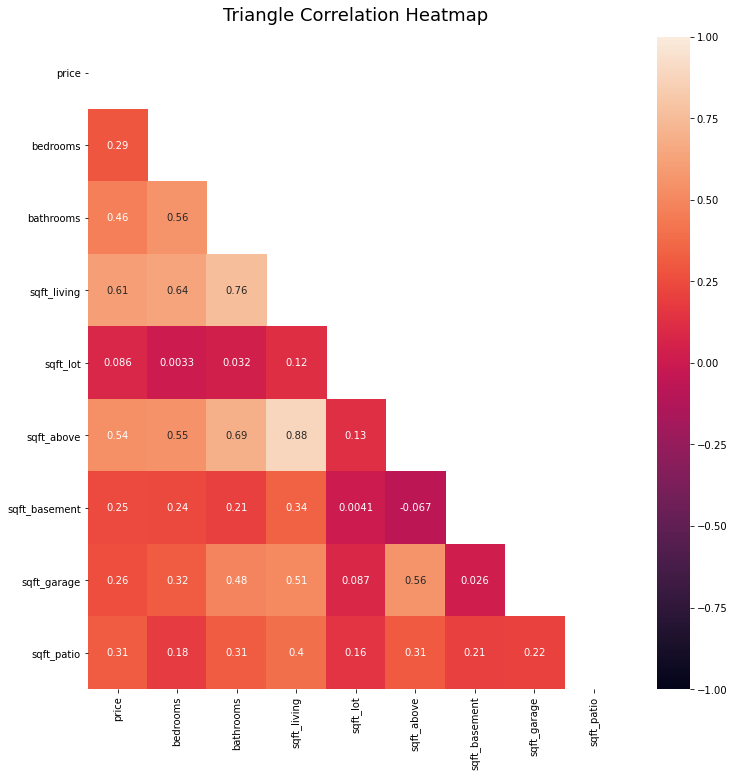

In [52]:

plt.figure(figsize=(12, 12))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(basic_space_corr, dtype=bool))
heatmap = sns.heatmap(basic_space_corr, mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
heatmap.set_facecolor('white');

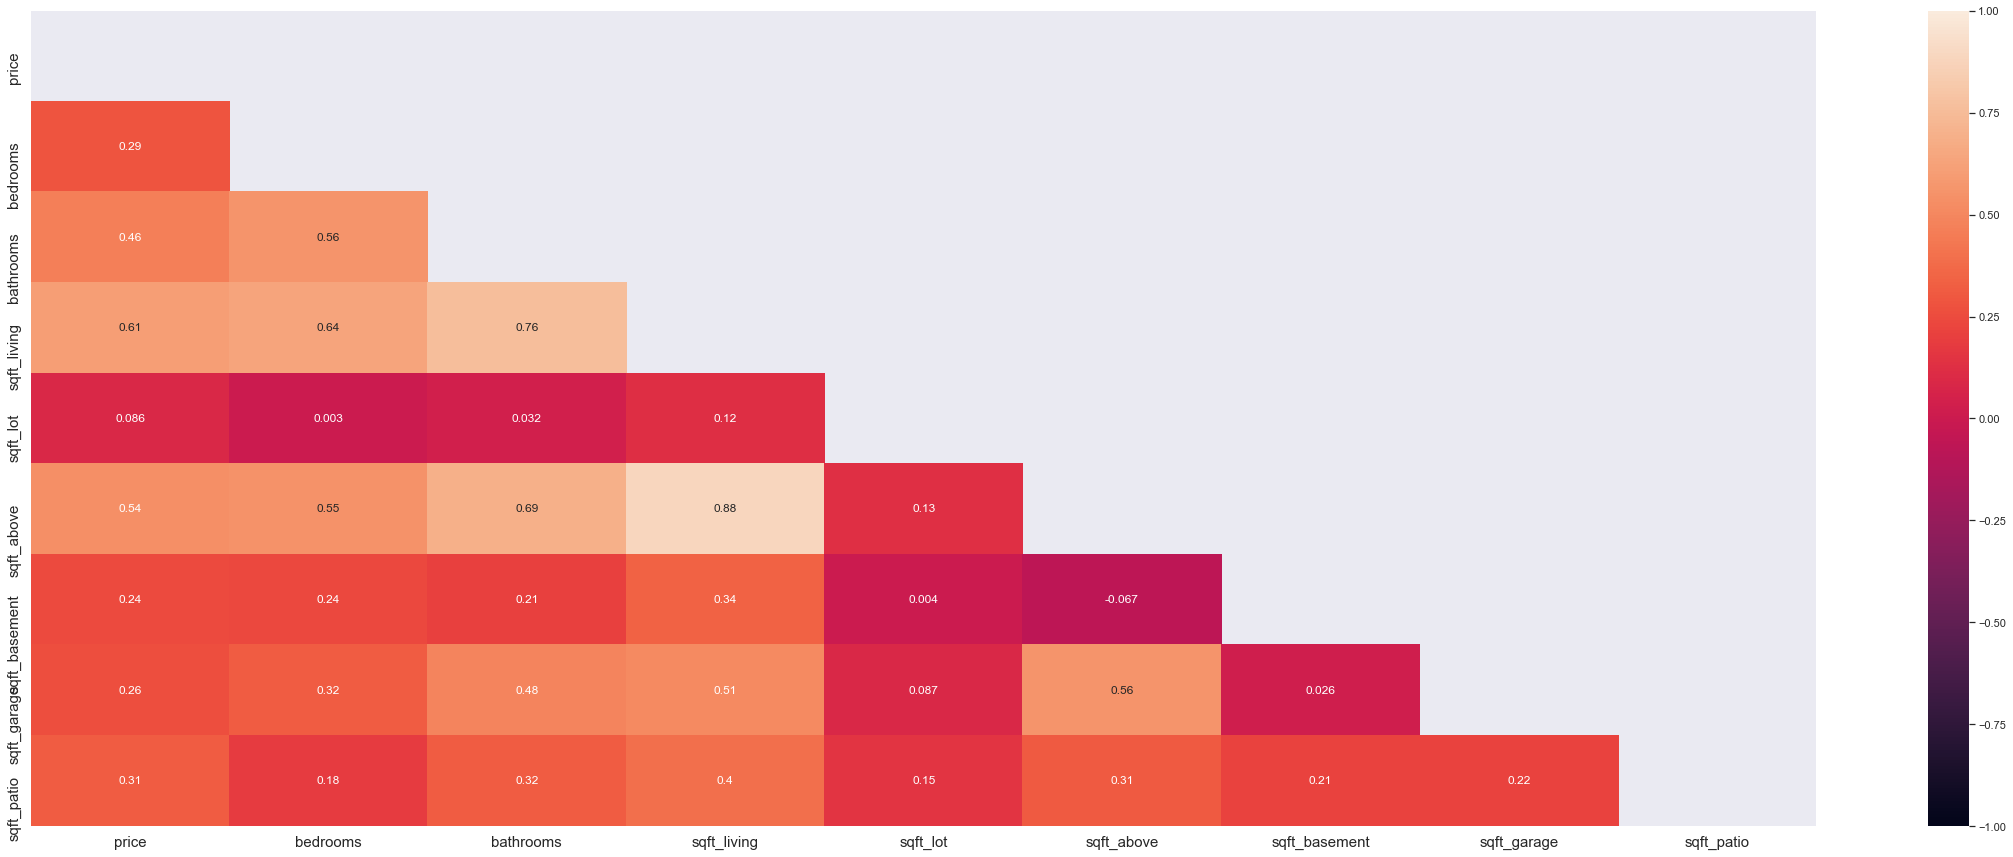

In [53]:
corr = round(basic_space_corr,3)
sns.set(rc = {'figure.figsize':(40,15)})
mask = np.triu(np.ones_like(corr, dtype=bool))
res = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 15)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 15);

<AxesSubplot:>

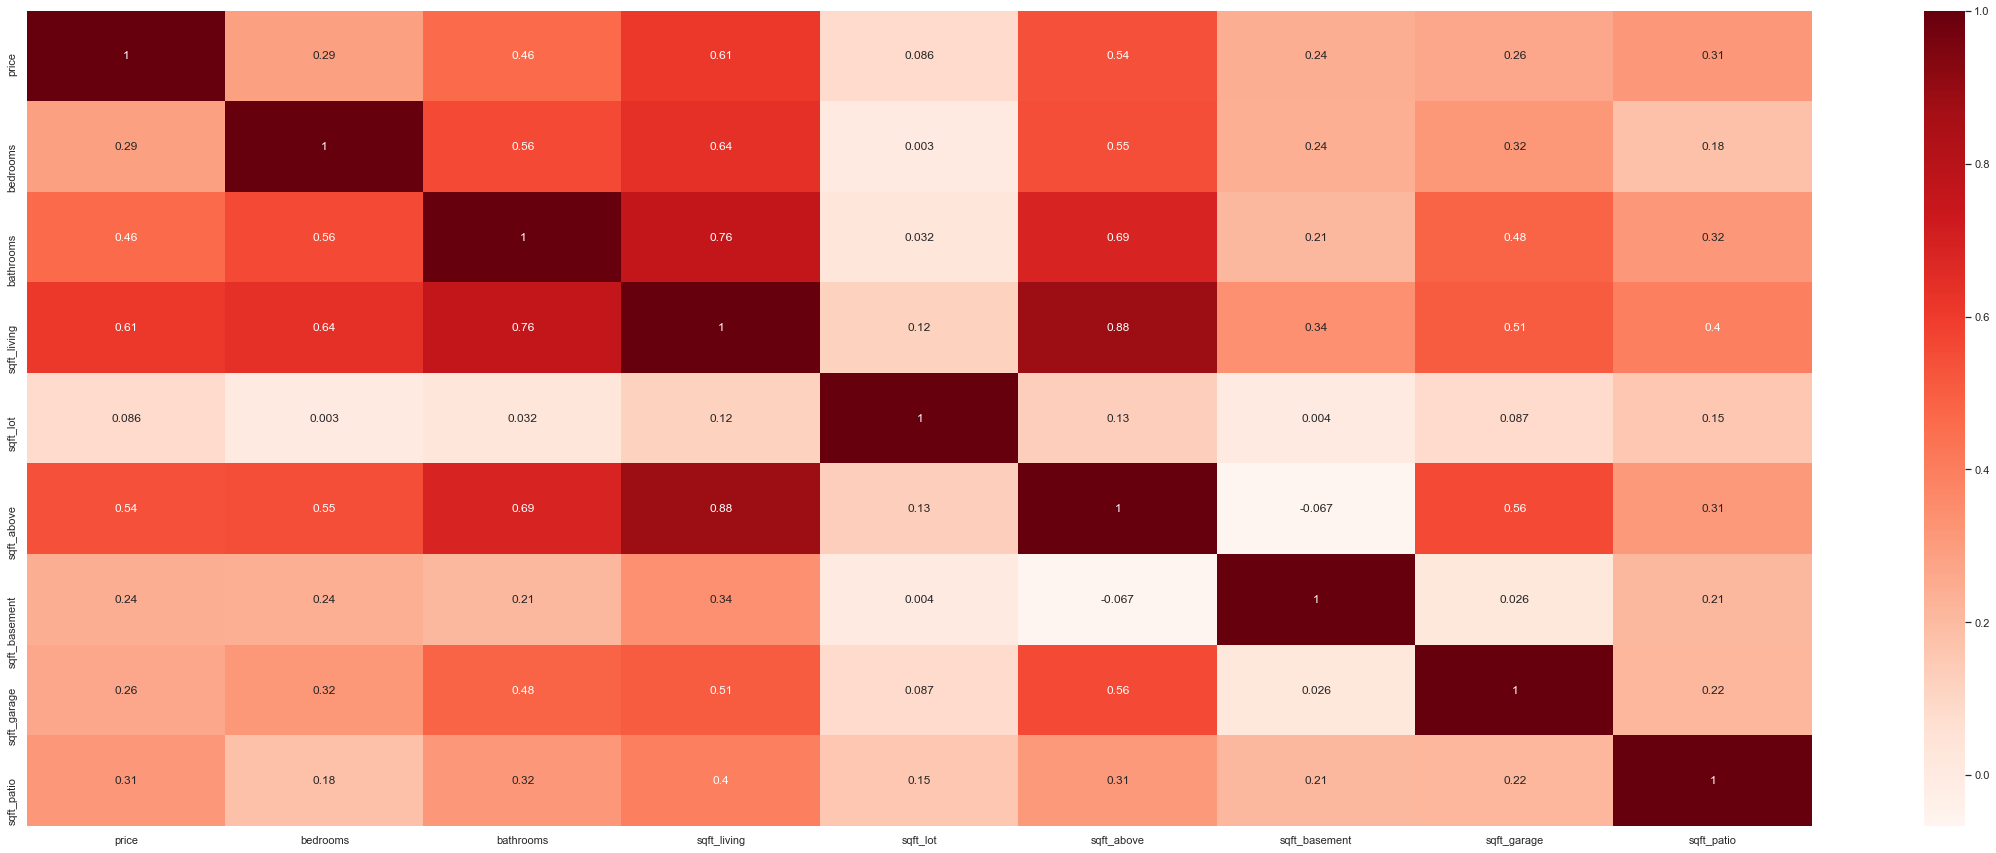

In [54]:
corr = round(basic_space_corr,3)
sns.set(rc = {'figure.figsize':(40,15)})
sns.heatmap(corr, cmap="Reds", annot=True)


Engineered spatial Columns

In [55]:

relevant = ['price', 'total_sqft', 'weighted__livsqft', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
            'sqft_garage', 'sqft_patio']

eng_space = X_train[relevant]

In [56]:
eng_space_corr = eng_space.corr()

eng_space_corr

,price,total_sqft,weighted__livsqft,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_garage,sqft_patio
price,1.000000,0.589347,0.667201,0.608521,0.085730,0.538651,0.245058,0.264169,0.313409
total_sqft,0.589347,1.000000,0.914813,0.933705,0.137356,0.826481,0.445460,0.649964,0.540021
weighted__livsqft,0.667201,0.914813,1.000000,0.967921,0.119600,0.877782,0.296960,0.524116,0.401582
sqft_living,0.608521,0.933705,0.967921,1.000000,0.119563,0.883984,0.338460,0.511740,0.396030
sqft_lot,0.085730,0.137356,0.119600,0.119563,1.000000,0.129231,0.004111,0.087169,0.155250
sqft_above,0.538651,0.826481,0.877782,0.883984,0.129231,1.000000,-0.066801,0.560551,0.312117
sqft_basement,0.245058,0.445460,0.296960,0.338460,0.004111,-0.066801,1.000000,0.026361,0.210500
sqft_garage,0.264169,0.649964,0.524116,0.511740,0.087169,0.560551,0.026361,1.000000,0.216354
sqft_patio,0.313409,0.540021,0.401582,0.396030,0.155250,0.312117,0.210500,0.216354,1.000000


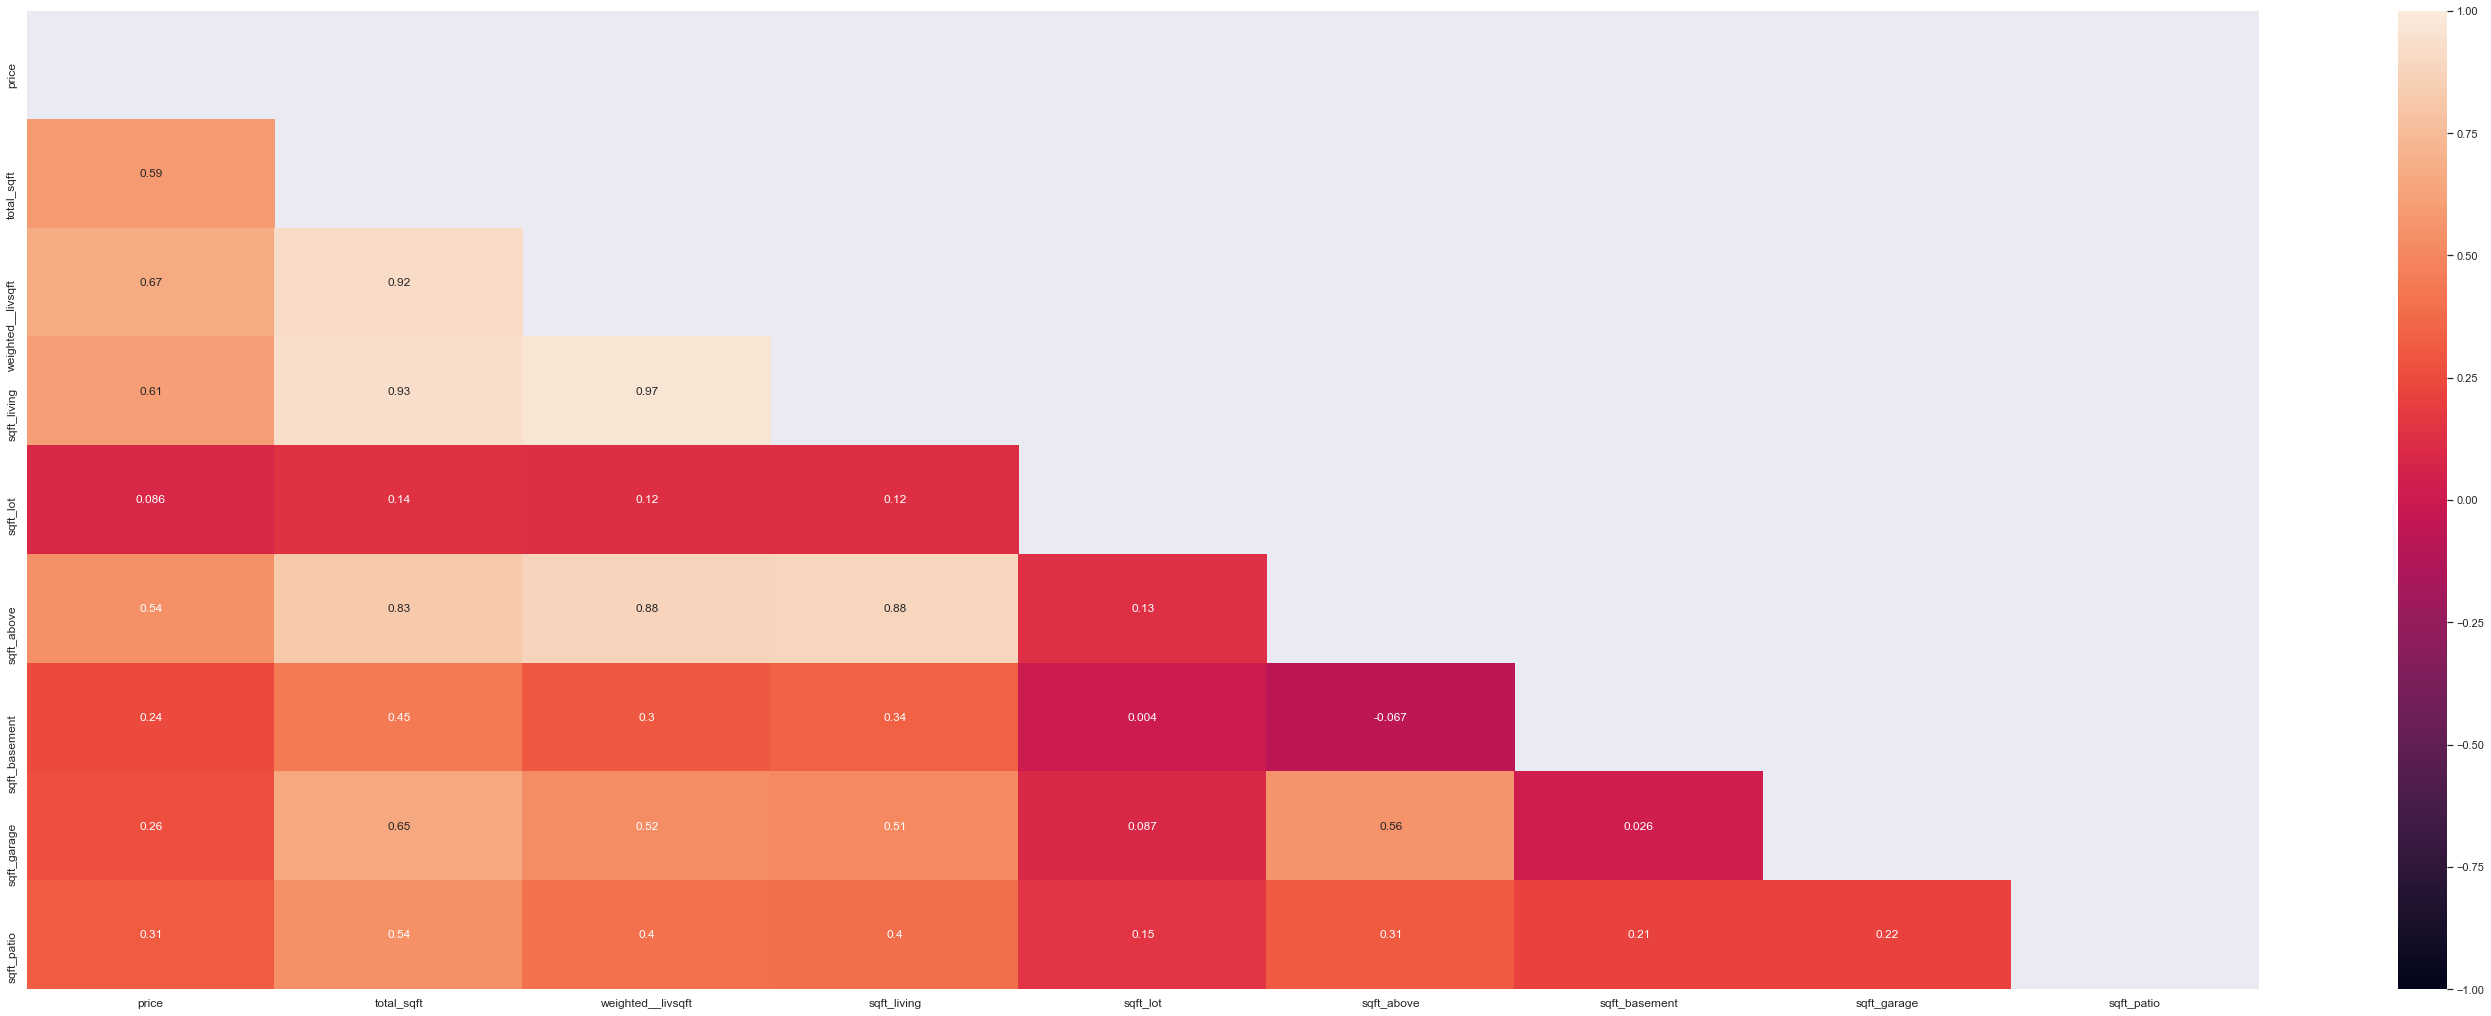

In [57]:
corr = round(eng_space_corr,3)
sns.set(rc = {'figure.figsize':(50,18)})
mask = np.triu(np.ones_like(corr, dtype=bool))
res = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12);

Basic categorical Columns

In [58]:
list(X_train.columns)

['date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'condition',
 'grade',
 'sewer_system',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'yr_renovated',
 'address',
 'zip',
 'city',
 'sale_year',
 'home_age',
 'yr_from_reno',
 'design_age',
 'basement_binary',
 'garage_binary',
 'patio_binary',
 'waterfront_binary',
 'PublicSewer_binary',
 'yrenovated_binary',
 'total_sqft',
 'weighted__livsqft',
 'design_decade',
 'yard_size_ratio',
 'view_grade',
 'waterfront_grade',
 'design_decade_grade',
 'nuisance_grade',
 'garage_binary_grade',
 'basement_binary_grade',
 'patio_binary_grade',
 'PublicSewer_binary_grade',
 'condition_grade']

In [59]:
relevant = ['price', 'waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade','basement_binary', 'garage_binary',
            'patio_binary', 'waterfront_binary', 'PublicSewer_binary', 'yrenovated_binary','design_decade']

bas_cat = X_train[relevant]

In [60]:
bas_cat_corr = bas_cat.corr()

bas_cat_corr

,price,greenbelt,nuisance,view,condition,grade,basement_binary,garage_binary,patio_binary,waterfront_binary,PublicSewer_binary,yrenovated_binary,design_decade
price,1.000000,0.068256,0.011547,0.315265,-0.008704,0.565263,0.103376,0.109485,0.148891,0.232250,0.021788,0.084515,0.125568
greenbelt,0.068256,1.000000,-0.053012,-0.009099,-0.029067,0.118615,-0.051809,0.101851,0.053981,-0.019851,0.025151,-0.028364,0.100646
nuisance,0.011547,-0.053012,1.000000,0.025536,-0.021887,-0.061788,0.108323,-0.139243,-0.050155,0.009026,0.003213,0.045109,-0.108619
view,0.315265,-0.009099,0.025536,1.000000,0.031295,0.198986,0.181590,-0.031759,0.099997,0.425007,-0.053163,0.110138,-0.050322
condition,-0.008704,-0.029067,-0.021887,0.031295,1.000000,-0.153135,0.058598,-0.065237,-0.026490,0.002685,-0.088258,-0.078743,-0.363353
grade,0.565263,0.118615,-0.061788,0.198986,-0.153135,1.000000,0.028544,0.339163,0.257681,0.042152,0.017999,-0.012420,0.484089
basement_binary,0.103376,-0.051809,0.108323,0.181590,0.058598,0.028544,1.000000,-0.090750,0.085397,0.012382,0.109585,0.053774,-0.224352
garage_binary,0.109485,0.101851,-0.139243,-0.031759,-0.065237,0.339163,-0.090750,1.000000,0.107436,-0.062667,0.008368,-0.115777,0.388372
patio_binary,0.148891,0.053981,-0.050155,0.099997,-0.026490,0.257681,0.085397,0.107436,1.000000,0.041788,-0.020865,0.026164,0.211651
waterfront_binary,0.232250,-0.019851,0.009026,0.425007,0.002685,0.042152,0.012382,-0.062667,0.041788,1.000000,-0.125686,0.098357,-0.014780


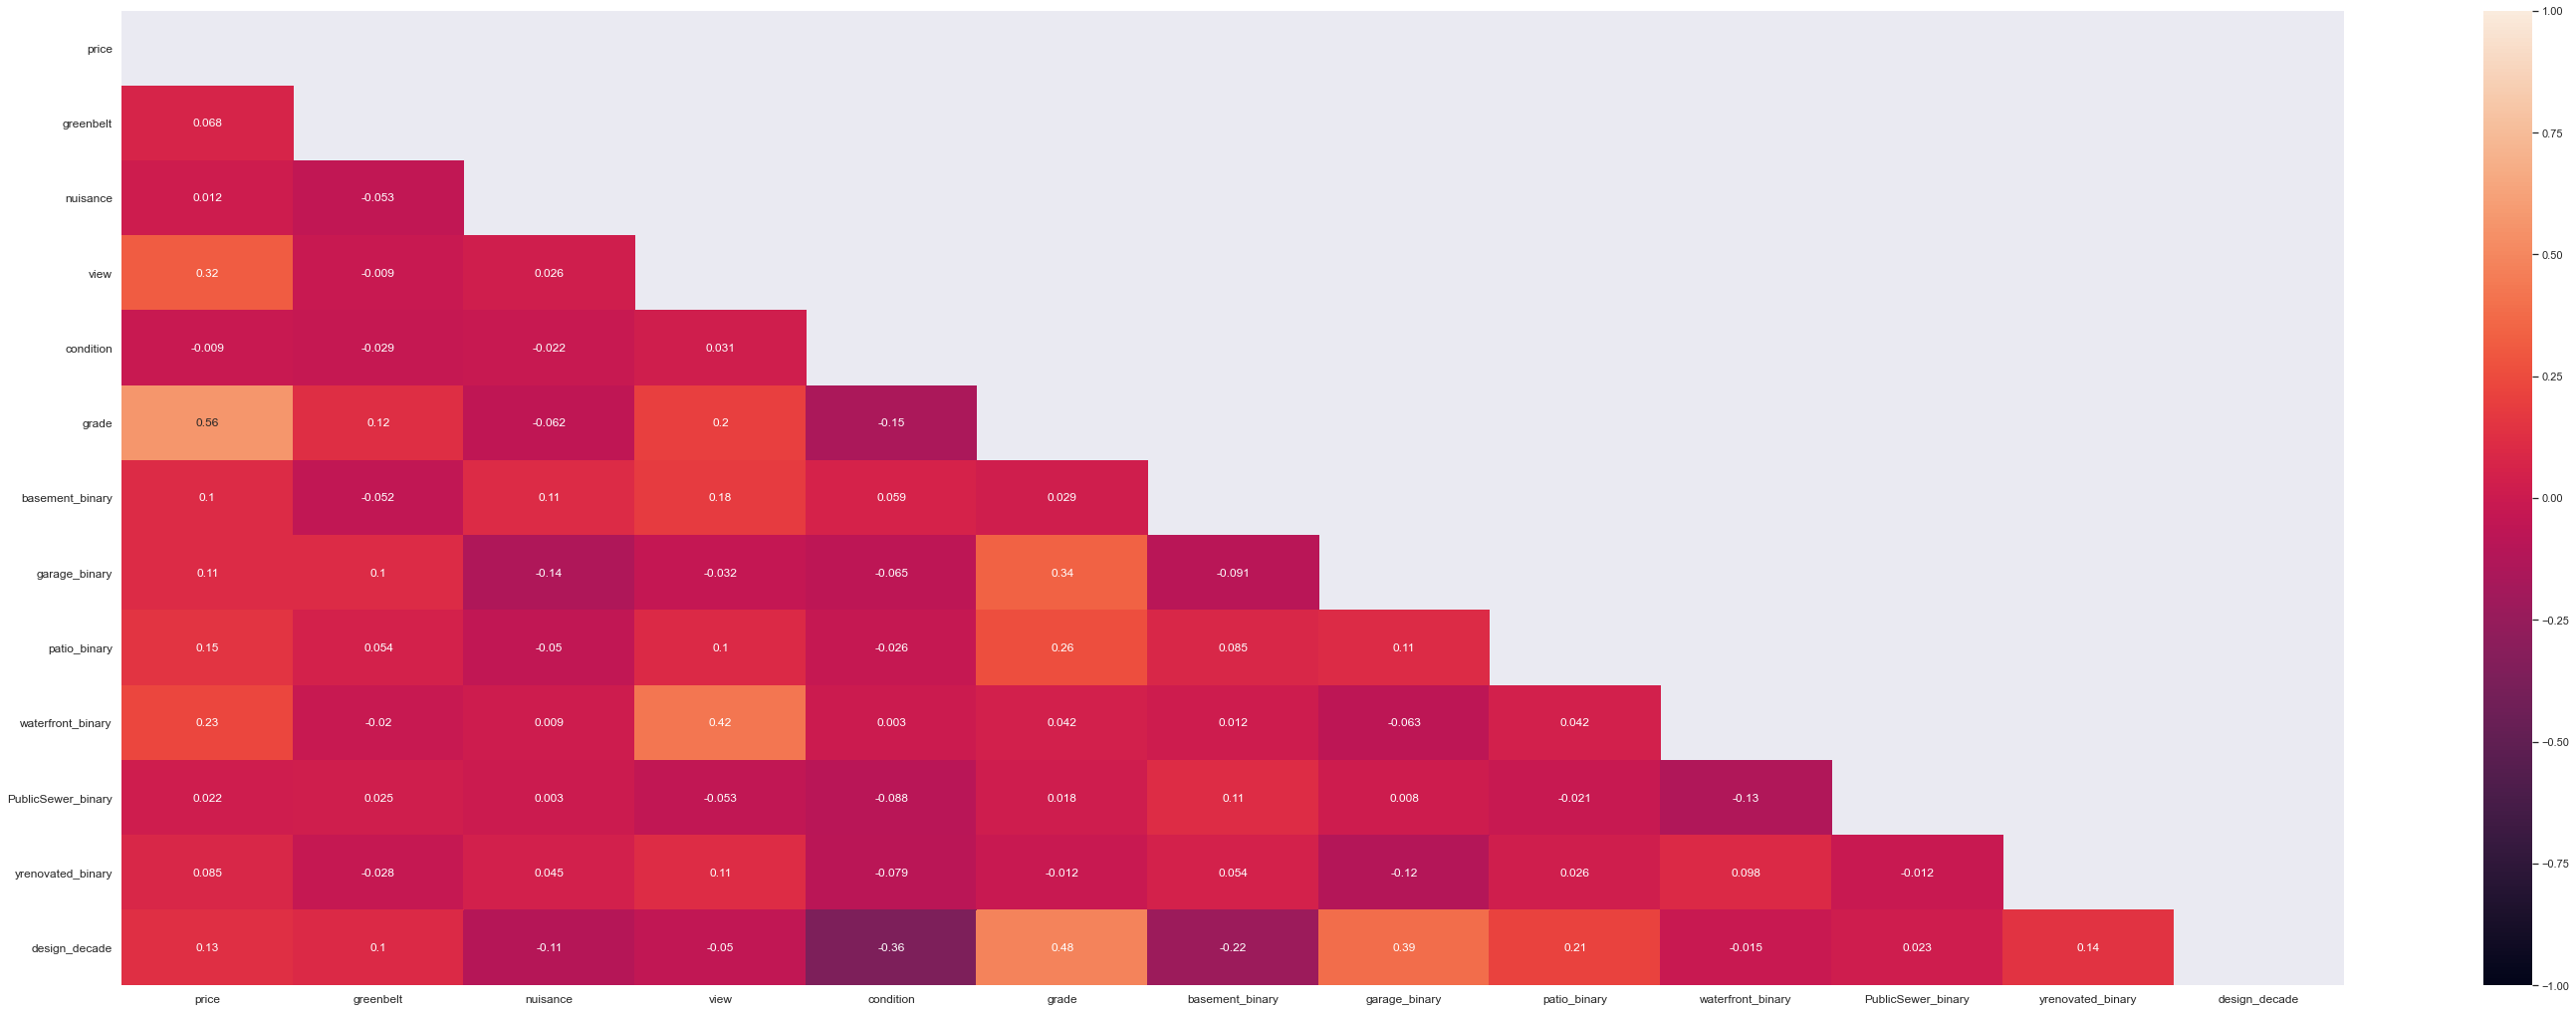

In [61]:
corr = round(bas_cat_corr,3)
sns.set(rc = {'figure.figsize':(50,18)})
mask = np.triu(np.ones_like(corr, dtype=bool))
res = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12);

engineered categorical Columns

In [62]:
list(X_train.columns)

['date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'condition',
 'grade',
 'sewer_system',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'yr_renovated',
 'address',
 'zip',
 'city',
 'sale_year',
 'home_age',
 'yr_from_reno',
 'design_age',
 'basement_binary',
 'garage_binary',
 'patio_binary',
 'waterfront_binary',
 'PublicSewer_binary',
 'yrenovated_binary',
 'total_sqft',
 'weighted__livsqft',
 'design_decade',
 'yard_size_ratio',
 'view_grade',
 'waterfront_grade',
 'design_decade_grade',
 'nuisance_grade',
 'garage_binary_grade',
 'basement_binary_grade',
 'patio_binary_grade',
 'PublicSewer_binary_grade',
 'condition_grade']

In [63]:
relevant = ['price', 'view_grade', 'waterfront_grade', 'design_decade_grade',
            'nuisance_grade', 'garage_binary_grade', 'basement_binary_grade',
            'patio_binary_grade', 'PublicSewer_binary_grade', 'condition_grade']

eng_cat = X_train[relevant]

In [64]:
eng_cat_corr = eng_cat.corr()

eng_cat_corr

,price,view_grade,waterfront_grade,design_decade_grade,nuisance_grade,garage_binary_grade,basement_binary_grade,patio_binary_grade,PublicSewer_binary_grade,condition_grade
price,1.000000,0.456478,0.597765,0.318265,0.288378,0.360013,0.351405,0.428755,0.391974,0.394524
view_grade,0.456478,1.000000,0.572472,0.208392,0.222292,0.247922,0.372582,0.345188,0.267573,0.309779
waterfront_grade,0.597765,0.572472,1.000000,0.568605,0.354710,0.540263,0.384447,0.596560,0.485503,0.471092
design_decade_grade,0.318265,0.208392,0.568605,1.000000,0.273070,0.639587,0.178534,0.590933,0.507286,0.212930
nuisance_grade,0.288378,0.222292,0.354710,0.273070,1.000000,0.232721,0.293835,0.297383,0.295006,0.231222
garage_binary_grade,0.360013,0.247922,0.540263,0.639587,0.232721,1.000000,0.249407,0.531084,0.469327,0.401464
basement_binary_grade,0.351405,0.372582,0.384447,0.178534,0.293835,0.249407,1.000000,0.377834,0.379829,0.322532
patio_binary_grade,0.428755,0.345188,0.596560,0.590933,0.297383,0.531084,0.377834,1.000000,0.475850,0.427674
PublicSewer_binary_grade,0.391974,0.267573,0.485503,0.507286,0.295006,0.469327,0.379829,0.475850,1.000000,0.325702
condition_grade,0.394524,0.309779,0.471092,0.212930,0.231222,0.401464,0.322532,0.427674,0.325702,1.000000


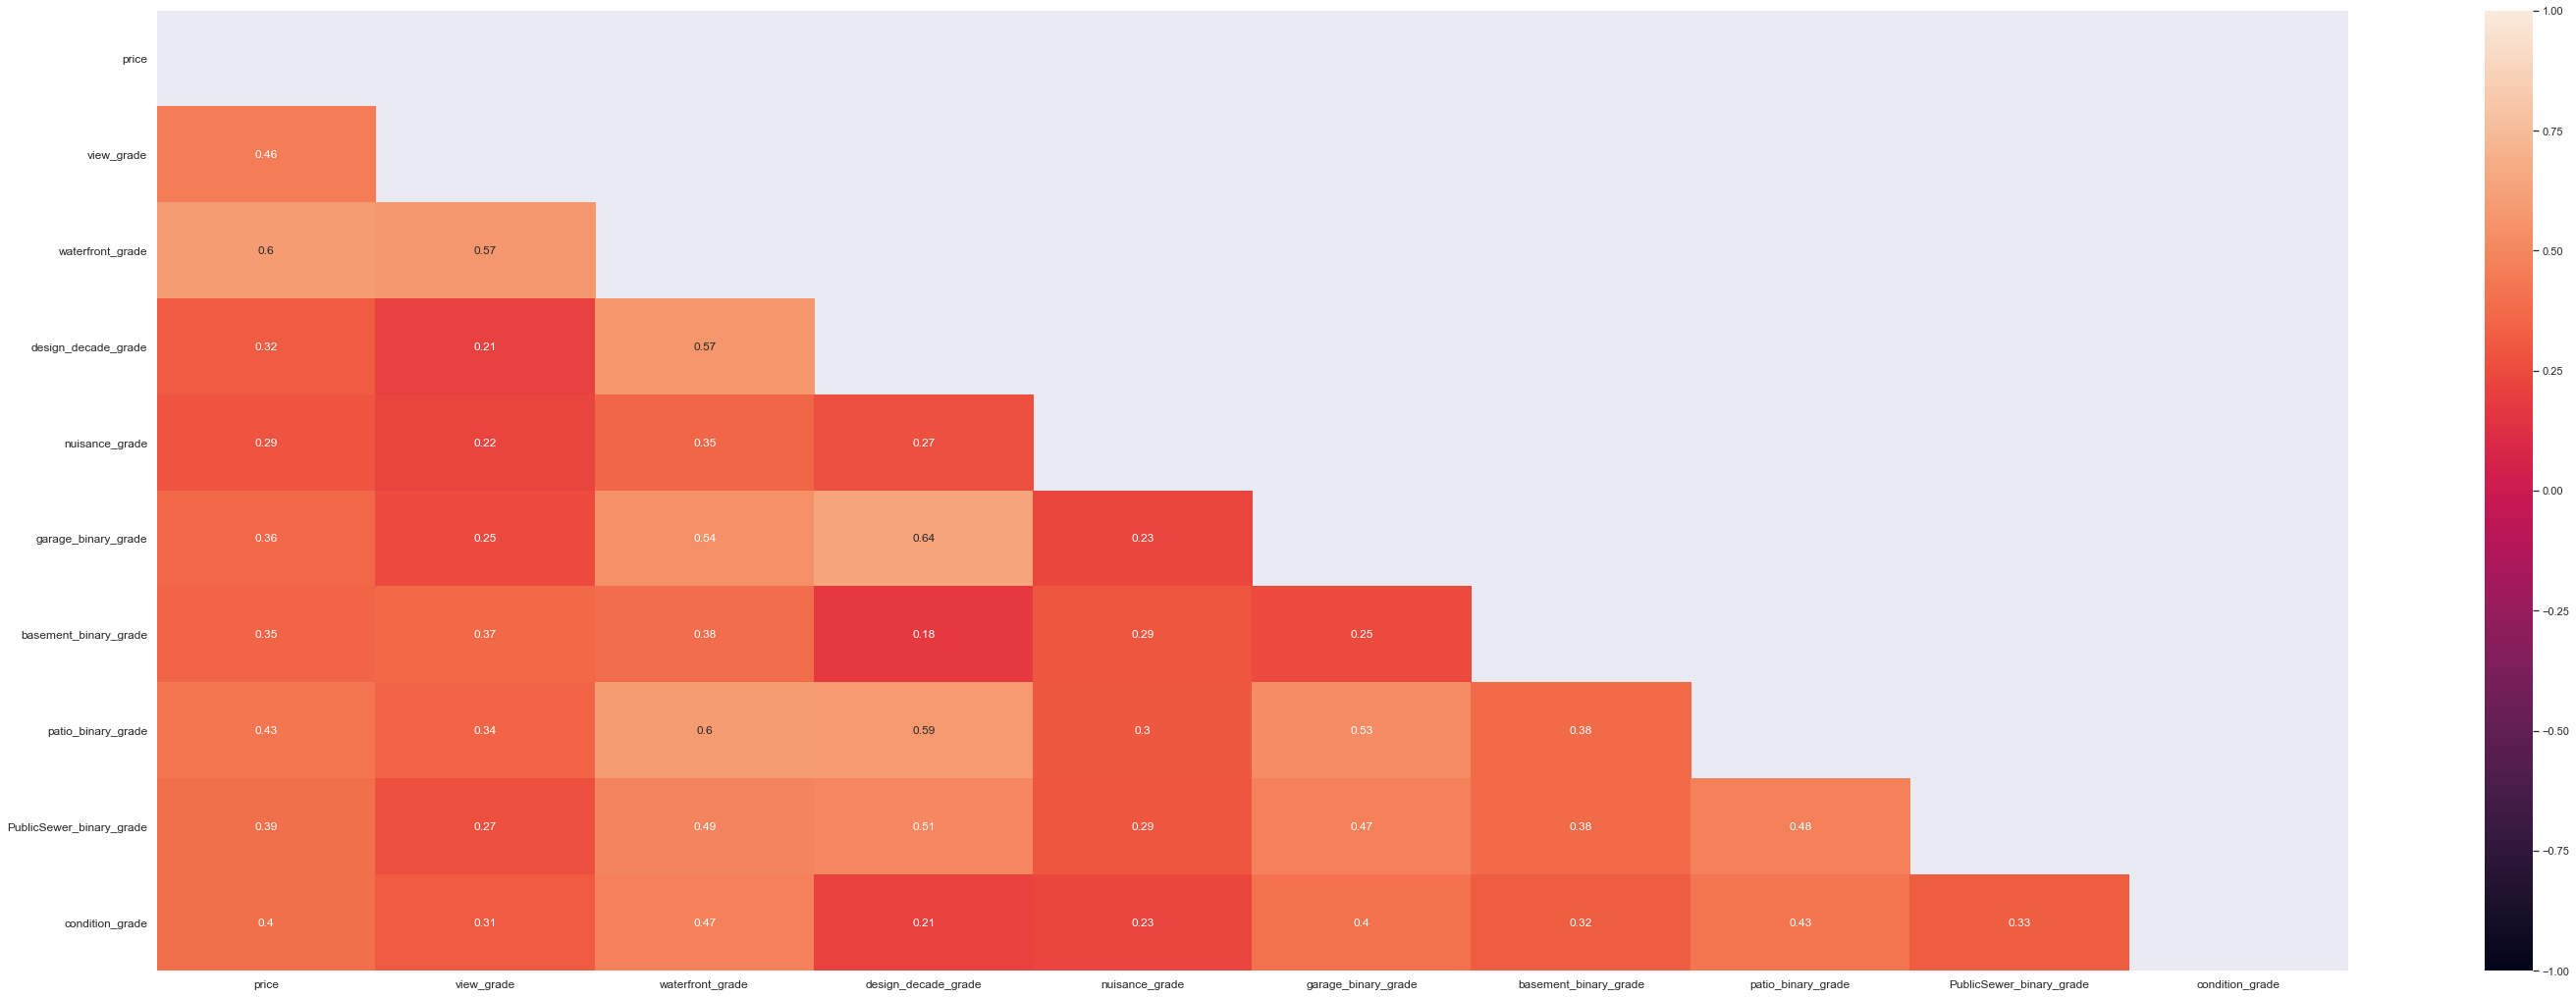

In [65]:
corr = round(eng_cat_corr,3)
sns.set(rc = {'figure.figsize':(50,18)})
mask = np.triu(np.ones_like(corr, dtype=bool))
res = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12);

### Messing Around - weights of the variables

In [37]:
X_standard = X.apply(lambda x: (x-x.mean())/ x.std())

In [38]:
results_standardized = sm.OLS(y, sm.add_constant(X_standard)).fit()

In [39]:
weights = results_standardized.params
weights

const            1.108536e+06
id              -8.165048e+03
bedrooms        -1.632184e+05
bathrooms        1.256806e+05
sqft_living      3.264095e+05
sqft_lot        -5.622398e+03
floors          -4.832488e+03
sqft_above       2.538405e+05
sqft_basement    9.470959e+04
sqft_garage     -4.193358e+04
sqft_patio       6.504756e+04
yr_built        -1.027304e+05
yr_renovated     2.103649e+04
lat              4.544287e+04
long             6.715172e+04
sale_year        8.160777e+04
dtype: float64

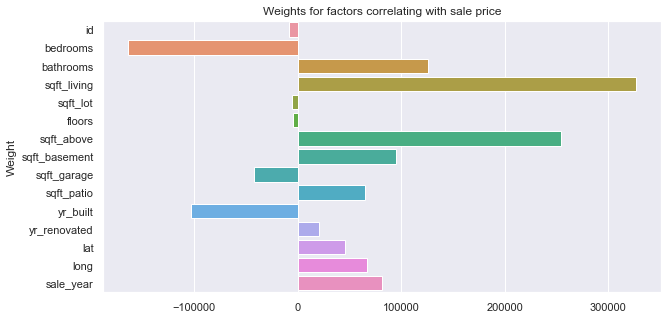

In [40]:
plt.figure(figsize=(10,5))
sns.barplot(y = weights[1::].index, x = weights[1::].values)
plt.title("Weights for factors correlating with sale price")
plt.ylabel('Weight')
plt.show()